In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time

In [2]:
df = pd.read_csv('Try data mining/afdata/AF_Stock_TW_1301.TW.csv')

In [3]:
df = df.drop(['key_0'], axis='columns')

In [4]:
# 保留前 100 row 空值小於等於 60% 的 column
df = df[df.columns[df.iloc[:101,:].isnull().sum()/100 <= 0.6]]

In [5]:
# 刪除前 58 row 當新的 df
df.drop([x for x in range(58)], axis='index', inplace=True)

In [6]:
# index reset
df.reset_index(drop=True, inplace=True)

In [7]:
df

,open,high,low,close,volume,ht_dcperiod,inphase,quadrature,ht_trendmode,add,...,day,weekofyear,dayofyear,dayofweek,bias,ama,psy,dpo,vhf,rvi
0,65.568988,66.817919,65.256752,66.193451,16364400.0,21.675377,-0.084339,1.179410,0,132.074670,...,6,14,96,3,0.062710,1.331361,50.000000,2.299174,0.348485,0.053824
1,66.817919,67.130155,64.007821,66.193451,17040400.0,21.813179,0.808491,2.935545,0,131.137976,...,7,14,97,4,0.057779,1.562289,50.000000,2.043710,0.389831,0.035007
2,66.193459,66.193459,64.944528,65.256760,9403680.0,22.217000,2.162174,1.898309,0,131.137987,...,8,14,98,5,0.037839,1.763492,45.833333,0.879939,0.379121,0.016787
3,65.568985,65.568985,64.944517,65.568985,5519280.0,22.792088,2.033302,-0.532854,0,130.513502,...,11,15,101,1,0.036218,1.933846,45.833333,0.993470,0.376022,-0.016290
4,65.568979,65.568979,63.695576,64.944511,12793040.0,23.401725,1.481944,-0.619500,0,129.264555,...,12,15,102,2,0.020709,2.074851,45.833333,0.170303,0.367021,0.028569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,103.500000,104.000000,102.000000,103.000000,3044218.0,22.051860,-0.820773,-2.885485,0,206.000000,...,24,25,175,4,-0.005792,0.422000,50.000000,-0.136364,0.326683,0.135837
2504,102.500000,105.000000,102.500000,104.000000,7467282.0,22.057605,-2.031413,-2.632432,0,207.500000,...,25,25,176,5,0.002410,0.245000,50.000000,0.772727,0.248718,0.146439
2505,104.500000,105.000000,102.500000,103.000000,5593404.0,22.538018,-3.167910,-0.078245,0,207.500000,...,28,26,179,1,-0.007946,0.057000,45.833333,0.000000,0.273239,0.098654
2506,102.500000,104.500000,102.000000,104.000000,6156300.0,23.225823,-2.330788,5.442106,0,206.500000,...,29,26,180,2,0.001444,-0.119000,45.833333,0.954545,0.270195,0.129233


In [8]:
def split_data(stock, lookback, gapspace=0, test_set_size=120):
    # data_raw = stock.to_numpy() # convert to numpy array
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback,:])
    
    data = np.array(data);

    # test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1-gapspace,:]
    y_train = data[:train_set_size,-1,3:4]
    x_test = data[train_set_size:,:-1-gapspace,:]
    y_test = data[train_set_size:,-1,3:4]
    
    print('x_train.shape = ',x_train.shape)
    print('y_train.shape = ',y_train.shape)
    print('x_test.shape = ',x_test.shape)
    print('y_test.shape = ',y_test.shape)
    
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    y_train= torch.from_numpy(y_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_test= torch.from_numpy(y_test).type(torch.Tensor)
    
    return x_train, y_train, x_test, y_test

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [10]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [19]:
def LSTM_train_prediction(epochs, x_train, y_train, x_test):
    
    hist = np.zeros(epochs+1)

    for i in range(epochs+1):
        y_train_pred = modelL(x_train)
        loss = criterion(y_train_pred, y_train)
        if i%10 == 0:
            print("Epoch ", i, "MSE: ", loss.item())
        hist[i] = loss.item()
        optimiserL.zero_grad()
        loss.backward()
        optimiserL.step()

    y_test_pred = modelL(x_test)
    
    return y_test_pred, hist

In [20]:
def GRU_train_prediction(epochs, x_train, y_train, x_test):
    
    hist = np.zeros(epochs+1)

    for i in range(epochs+1):
        y_train_pred = modelG(x_train)
        loss = criterion(y_train_pred, y_train)
        if i%10 == 0:
            print("Epoch ", i, "MSE: ", loss.item())
        hist[i] = loss.item()
        optimiserG.zero_grad()
        loss.backward()
        optimiserG.step()

    y_test_pred = modelG(x_test)
    
    return y_test_pred, hist

### START

In [13]:
scaler = MinMaxScaler()
scaler_data = scaler.fit_transform(df.values)

In [14]:
x_train, y_train, x_test, y_test = split_data(scaler_data, lookback=20, gapspace=0, test_set_size=120)

x_train.shape =  (2368, 19, 183)
y_train.shape =  (2368, 1)
x_test.shape =  (120, 19, 183)
y_test.shape =  (120, 1)


In [21]:
modelL = LSTM(input_dim=183, hidden_dim=32, output_dim=1, num_layers=2)
modelG = GRU(input_dim=183, hidden_dim=32, output_dim=1, num_layers=2)
criterion = torch.nn.MSELoss(reduction='mean')
optimiserL = torch.optim.Adam(modelL.parameters(), lr=0.01)
optimiserG = torch.optim.Adam(modelG.parameters(), lr=0.01)

In [22]:
y_test_pred, hist = LSTM_train_prediction(epochs=100, x_train=x_train, y_train=y_train, x_test=x_test)

Epoch  0 MSE:  0.29913944005966187
Epoch  10 MSE:  0.04396747425198555
Epoch  20 MSE:  0.002660847967490554
Epoch  30 MSE:  0.0031142374500632286
Epoch  40 MSE:  0.0010034855222329497
Epoch  50 MSE:  0.0009590431582182646
Epoch  60 MSE:  0.0005990869249217212
Epoch  70 MSE:  0.0005241677863523364
Epoch  80 MSE:  0.0004512907180469483
Epoch  90 MSE:  0.0003899892617482692
Epoch  100 MSE:  0.00035244502942077816


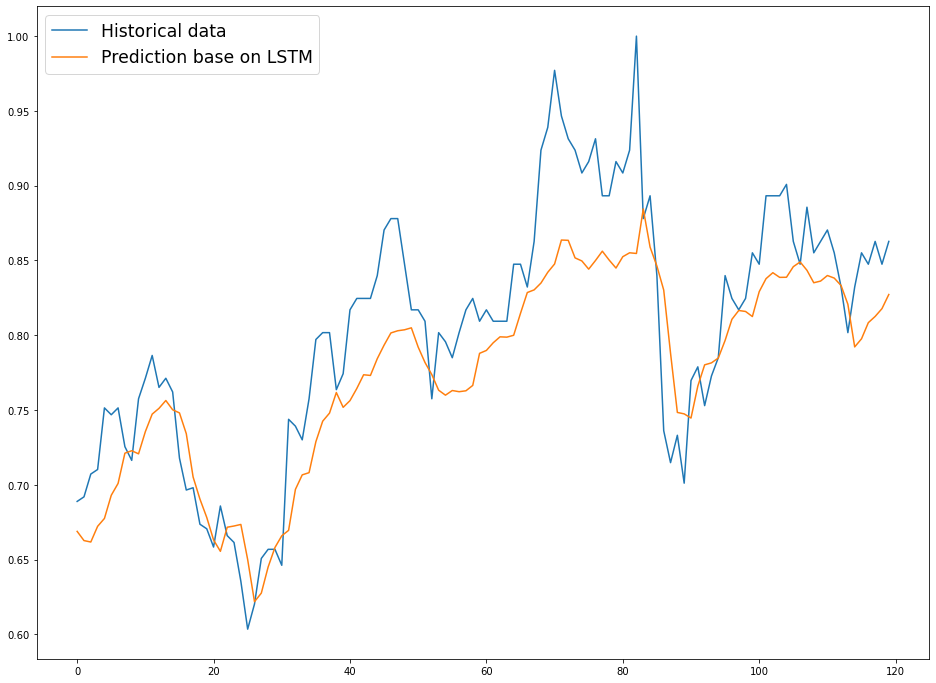

In [23]:
plt.figure(figsize=(16, 12))

plt.plot(y_test, label='Historical data')
plt.plot(y_test_pred.detach().numpy(), label='Prediction base on LSTM')
plt.legend(fontsize='xx-large', loc='upper left')

plt.show()

In [ ]:
hist = np.zeros(num_epochs+1)

for t in range(num_epochs+1):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    if t%10 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

y_test_pred = model(x_test)

In [ ]:
def allprocessLSTM(df, lookback, input_dim, output_dim, num_epochs):

  # plt.figure(figsize=(16, 12))
  # plt.plot(df['Close'])
  # plt.show()

  scaler = MinMaxScaler()
  scaler_data = scaler.fit_transform(df.values)

  def split_data(stock, lookback):
    # data_raw = stock.to_numpy() # convert to numpy array
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback,:])
    
    data = np.array(data);

    # print(data)
    # print(data.shape)

    # test_set_size = int(np.round(0.2*data.shape[0]));
    test_set_size = 120
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,3:4]
    
    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,3:4]
    
    return [x_train, y_train, x_test, y_test]

  x_train, y_train, x_test, y_test = split_data(scaler_data, lookback)

  x_train = torch.from_numpy(x_train).type(torch.Tensor)
  x_test = torch.from_numpy(x_test).type(torch.Tensor)
  y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
  y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
  y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
  y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

  input_dim = input_dim
  hidden_dim = 32
  num_layers = 2
  output_dim = output_dim
  num_epochs = num_epochs

  class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

  model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
  criterion = torch.nn.MSELoss(reduction='mean')
  optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

  hist = np.zeros(num_epochs+1)
  start_time = time.time()
  lstm = []

  for t in range(num_epochs+1):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    if t%10 == 0:
      print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

  training_time = time.time()-start_time
  print("Training time: {}".format(training_time))

  y_test_pred = model(x_test)

  return y_test_pred, y_test

In [ ]:
def allprocessGRU(df, lookback, input_dim, output_dim, num_epochs):

  # plt.figure(figsize=(16, 12))
  # plt.plot(df['Close'])
  # plt.show()

  scaler = MinMaxScaler()
  scaler_data = scaler.fit_transform(df.values)

  def split_data(stock, lookback):
    # data_raw = stock.to_numpy() # convert to numpy array
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback,:])
    
    data = np.array(data);

    # print(data)
    # print(data.shape)

    # test_set_size = int(np.round(0.2*data.shape[0]));
    test_set_size = 120
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,3:4]
    
    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,3:4]
    
    return [x_train, y_train, x_test, y_test]

  x_train, y_train, x_test, y_test = split_data(scaler_data, lookback)

  x_train = torch.from_numpy(x_train).type(torch.Tensor)
  x_test = torch.from_numpy(x_test).type(torch.Tensor)
  y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
  y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
  y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
  y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

  input_dim = input_dim
  hidden_dim = 32
  num_layers = 2
  output_dim = output_dim
  num_epochs = num_epochs

  class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

  model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
  criterion = torch.nn.MSELoss(reduction='mean')
  optimiser = torch.optim.Adam(model.parameters(), lr=0.01)     

  hist = np.zeros(num_epochs+1)
  start_time = time.time()
  gru = []

  for t in range(num_epochs+1):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_gru)
    if t%10 == 0:
      print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

  training_time = time.time()-start_time
  print("Training time: {}".format(training_time))

  y_test_pred = model(x_test)

  return y_test_pred, y_test

In [ ]:
y_pred_base10y_LSTM, y_test = op.allprocessLSTM(df, 20, 183, 1, 100)
# y_pred_base10y_GRU, y_test = allprocessGRU(df, 20, 5, 1, 500)

In [ ]:
plt.figure(figsize=(16, 12))

plt.plot(y_test, label='Historical data')
plt.plot(y_pred_base10y_LSTM.detach().numpy(), label='Prediction base on LSTM')
plt.legend(fontsize='xx-large', loc='upper left')

plt.show()

In [ ]:
plt.figure(figsize=(16, 12))

plt.plot(y_test, label='Historical data')
plt.plot(y_pred_base10y_LSTM.detach().numpy(), label='Prediction base on LSTM')
plt.plot(y_pred_base10y_GRU.detach().numpy(), label='Prediction base on GRU')
plt.legend(fontsize='xx-large', loc='upper left')

plt.show()

In [ ]:
df2y = dft[dft['Date'].between('2019-06-30', '2021-06-30')]

In [ ]:
df2y = df2y.drop(['Date', 'Dividends', 'Stock Splits'], axis = 1)

In [ ]:
y_pred_base2y_LSTM, y_test = allprocessLSTM(df2y, 20, 5, 1, 500)
y_pred_base2y_GRU, y_test = allprocessGRU(df2y, 20, 5, 1, 500)

In [ ]:
plt.figure(figsize=(16, 12))

plt.plot(y_test, label='Historical data')
plt.plot(y_pred_base10y_LSTM.detach().numpy(), label='Prediction base on 10y&LSTM')
plt.plot(y_pred_base10y_GRU.detach().numpy(), label='Prediction base on 10y&GRU')
plt.plot(y_pred_base2y_LSTM.detach().numpy(), label='Prediction base on 2y&LSTM')
plt.plot(y_pred_base2y_GRU.detach().numpy(), label='Prediction base on 2y&GRU')
plt.legend(fontsize='xx-large', loc='upper left')

plt.show()

In [ ]:
lookbacks = [3, 5, 10 , 20, 60]

plt.figure(figsize=(16, 12))

for lookback in lookbacks:

  print(f'Training for lookback : {lookback} ')
  y_pred, y_test = allprocess(df, lookback, 5, 1, 500)
  plt.plot(y_pred.detach().numpy(), label=f'Prediction for lookback : {lookback}')
  print('-'*80)

plt.plot(y_test, label='Historical data')
plt.legend(fontsize='xx-large', loc='upper left')
plt.show()

In [ ]:
scaler = MinMaxScaler()
scaler_data = scaler.fit_transform(df.values)
scaler_data

In [ ]:
def split_data(stock, lookback):
    # data_raw = stock.to_numpy() # convert to numpy array
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback,:])
    
    data = np.array(data);

    # print(data)
    # print(data.shape)

    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,3:4]
    
    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,3:4]
    
    return [x_train, y_train, x_test, y_test]


lookback = 10 # choose sequence length
x_train, y_train, x_test, y_test = split_data(scaler_data, lookback)

In [ ]:
x_train.shape

In [ ]:
x_test.shape

In [ ]:
y_train.shape

In [ ]:
y_test.shape

In [ ]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
input_dim = 5
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

In [ ]:
y_test_pred = model(x_test)

In [ ]:
len(y_test_pred)

In [ ]:
plt.figure(figsize=(16, 12))

plt.plot(y_test_lstm.detach().numpy())
plt.plot(y_test_pred.detach().numpy())
plt.leg

plt.show()

In [ ]:
y_train_lstm